# Imports

In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)

# Load data

In [2]:
data = pd.read_csv('data/DC_Properties.csv')
data

C:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
5,5,3,2,Hot Water Rad,Y,1.0,10,5,1913.0,NaN,...,-77.039715,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
6,6,1,0,Warm Cool,Y,2.0,5,2,1917.0,1988.0,...,-77.041055,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,-77.040429,38.914881,NW
7,7,3,1,Hot Water Rad,Y,2.0,8,4,1906.0,2011.0,...,-77.040129,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,-77.040429,38.914881,NW
8,8,3,1,Warm Cool,Y,2.0,7,3,1908.0,2008.0,...,-77.039903,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,-77.040429,38.914881,NW
9,9,1,1,Hot Water Rad,Y,1.0,6,2,1908.0,1979.0,...,-77.040081,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,-77.040429,38.914881,NW


In [3]:
# this command will throw away ~33% of the data (maybe we will keep the data and do two seperate tests, one where we will throw away the rows where the data is missing and one where we will throw away these columns)
# data = data[data["STRUCT"].notnull() | data["STYLE"].notnull() | data["GRADE"].notnull() | data["CNDTN"].notnull() | data["EXTWALL"].notnull() | data["ROOF"].notnull() | data["INTWALL"].notnull()]

# since our many concern is the price of the building, rows without the price have only a small to none value
data = data[data["PRICE"].notnull()]

# remove rows with strange prices
data = data.loc[(data["PRICE"] <= 25000000) & (data["PRICE"] >= 60000)]

# in these very few rows (~200) there are values missing
data = data[data["X"].notnull() & data["Y"].notnull() & data["QUADRANT"].notnull() & data["AYB"].notnull() & data["WARD"].notnull() & data["ASSESSMENT_NBHD"].notnull() & data["CENSUS_TRACT"].notnull() & data["LONGITUDE"].notnull() & data["LATITUDE"].notnull() & data["ZIPCODE"].notnull()]
data = data[data.ROOMS != 0]
data = data[data.AC != "0"]

In [4]:
# set the missing sale date to the year it was build
data["SALEDATE"] = np.where(data["SALEDATE"].isnull(), data["AYB"], data["SALEDATE"])

# add a column wich says wether a building was remodeled and insert missing values in to the YR_RMDL column
data["WAS_REMODELED"] = np.where(data["YR_RMDL"].isnull(), 0, 1)
data["YR_RMDL"] = np.where(data["YR_RMDL"].isnull(), -1, data["YR_RMDL"])

In [5]:
#convert saledate to datetime
data['SALEDATE'] = pd.to_datetime(data['SALEDATE'])
#Calculating the difference in years between Last Sale Date and Year Built
data['SalevYB']=data['SALEDATE'].dt.year - data['AYB']
#Calculating the difference in years between Last Sale Date and Year Improved
data['SalevYI']=data['SALEDATE'].dt.year - data['EYB']

data['SQUARE'] = data['SQUARE'].astype(str)

data = data.drop(["SALEDATE", "EYB", "AYB", "Unnamed: 0", "LIVING_GBA", "GIS_LAST_MOD_DTTM", "SOURCE", "CITY", "STATE"], axis=1)
data = data[data["STRUCT"].notnull() & data["STYLE"].notnull() & data["GRADE"].notnull() & data["CNDTN"].notnull() & data["EXTWALL"].notnull() & data["ROOF"].notnull() & data["INTWALL"].notnull()  & data["STORIES"].notnull() & data["KITCHENS"].notnull() & data["ASSESSMENT_SUBNBHD"].notnull()  & data["CENSUS_BLOCK"].notnull()]

In [6]:
data.columns

Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM',
       'YR_RMDL', 'STORIES', 'PRICE', 'QUALIFIED', 'SALE_NUM', 'GBA',
       'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF',
       'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'CMPLX_NUM',
       'FULLADDRESS', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT', 'CENSUS_BLOCK',
       'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT', 'WAS_REMODELED', 'SalevYB',
       'SalevYI'],
      dtype='object')

# Define methods

In [7]:
def chi2_test(row, col):
    table = pd.crosstab(row, col)
    chi2, p, df, exp_obs = scipy.stats.chi2_contingency(table)
    print(p)
    print(table)
    print(exp_obs)
    '''return chi2, p, exp_obs, df'''

In [8]:
def contingency_coefficent(row, col, return_C = False, return_mean_chi2 = False):
    if row.size != col.size:
        return None
    n = row.size
    c_table = pd.crosstab(row, col)
    exp_table = scipy.stats.contingency.expected_freq(c_table)
    chi2 = (pow(c_table - exp_table, 2) / exp_table).sum().sum()
    #print(chi2/n)
    C = pow(chi2 / (chi2 + n), 1/2)
    #print(C)
    Ckorr = C * pow(min(c_table.shape) / (min(c_table.shape) - 1), 1/2)
    if return_C:
        if return_mean_chi2:
            return Ckorr, C, chi2/(n * (min(c_table.shape) - 1))
        else:
            return Ckorr, C
    elif return_mean_chi2:
        return Ckorr, chi2/(n * (min(c_table.shape) - 1))
    else:
        return Ckorr

# Calculate Chi²-Tests

In [9]:
contingency_coefficent(data.SQUARE, data.QUADRANT)

0.9999999999999998

In [10]:
c_table_SQUARE_QUADRANT = pd.crosstab(data.SQUARE, data.QUADRANT)
chi2, p, df, exp_obs = scipy.stats.chi2_contingency(c_table_SQUARE_QUADRANT)
p

0.0

In [11]:
data.LONGITUDE.corr(data.X)

0.9998854642052089

In [12]:
c_table_LONGITUDE_X = pd.crosstab(data.LONGITUDE, data.X)
chi2, p, df, exp_obs = scipy.stats.chi2_contingency(c_table_LONGITUDE_X)
p

4.723597658221731e-196

In [13]:
data.LATITUDE.corr(data.Y)

0.9999104626920347

In [14]:
c_table_LATITUDE_Y = pd.crosstab(data.LATITUDE, data.Y)
chi2, p, df, exp_obs = scipy.stats.chi2_contingency(c_table_LATITUDE_Y)
p

0.0

In [15]:
contingency_coefficent(data.ASSESSMENT_NBHD, data.ASSESSMENT_SUBNBHD)

0.9995132725347345

In [16]:
c_table_NBHD_SUBNBHD = pd.crosstab(data.ASSESSMENT_NBHD, data.ASSESSMENT_SUBNBHD)
chi2, p, df, exp_obs = scipy.stats.chi2_contingency(c_table_NBHD_SUBNBHD)
p

0.0

In [17]:
contingency_coefficent(data.CENSUS_BLOCK, data.CENSUS_TRACT)

1.0

In [18]:
c_table_BLOCK_TRACT = pd.crosstab(data.CENSUS_BLOCK, data.CENSUS_TRACT)
chi2, p, df, exp_obs = scipy.stats.chi2_contingency(c_table_BLOCK_TRACT)
p

0.0

All correlation and chi² calculations show a high correlation and significance between the selected columns. (Small p value means that the null hypthesis that row and column are independent can be rejected.) They are all more or less geographical data about the specific property, so a high correlaltion can be expected. Because they have such high dependets, it is useful to drop some of the columns and only keep a few (one) that gives information about the location. Otherwise, the model would use independent variables that already have some relationship. 

In [19]:
contingency_coefficent(data.HEAT, data.AC, return_C=True, return_mean_chi2=True)

(0.7445666459936852, 0.5264881244274583, 0.3834889492896116)

In [20]:
contingency_coefficent(data.QUALIFIED, data.ROOF, return_C=True, return_mean_chi2=True)

(0.07394909324834048, 0.05228990529849789, 0.0027417307300445348)

In [21]:
categorical_cols = ["HEAT", "AC", "QUALIFIED", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "ROOF", 
                    "INTWALL", "ZIPCODE", "ASSESSMENT_NBHD", "ASSESSMENT_SUBNBHD", "CENSUS_TRACT", "CENSUS_BLOCK", 
                    "WARD", "SQUARE", "QUADRANT", "PRICE"]
numeric_cols = ["BATHRM", "HF_BATHRM", "NUM_UNITS", "ROOMS", "BEDRM", "YR_RMDL", "STORIES", "PRICE", "SALE_NUM", "GBA",
               "LANDAREA"]

Calculate the contigency coefficients for all categorical values:

In [22]:
def paired_contincency(data):
    names = data.columns.values.tolist()
    result_df = pd.DataFrame(index=names, columns=names)
    while len(names) > 0:
        i = names.pop(0)
        result_df[i][i] = 1
        for ii in names:
            try:
                result_df[i][ii] = result_df[ii][i] = contingency_coefficent(data[i], data[ii])
            except (TypeError, ZeroDivisionError):
                print(i, ii)
    return result_df

def paired_corr(data):
    names = data.columns.values.tolist()
    result_df = pd.DataFrame(index=names, columns=names)
    while len(names) > 0:
        i = names.pop(0)
        result_df[i][i] = 1
        for ii in names:
            result_df[i][ii] = result_df[ii][i] = data[i].corr(data[ii])
    return result_df

In [32]:
df = paired_contincency(data[categorical_cols])
df

,HEAT,AC,QUALIFIED,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,ZIPCODE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,QUADRANT,PRICE
HEAT,1,0.744567,0.151159,0.220895,0.257921,0.358609,0.416794,0.285521,0.333252,0.308738,0.478851,0.506757,0.564663,0.570975,0.814858,0.442295,0.796312,0.277132,0.849019
AC,0.744567,1,0.237362,0.205695,0.282082,0.304519,0.616269,0.210951,0.246095,0.187224,0.360939,0.395094,0.449133,0.460669,0.602741,0.308139,0.591029,0.0671344,0.639757
QUALIFIED,0.151159,0.237362,1,0.0824314,0.13953,0.156444,0.302916,0.0686165,0.0739491,0.0831081,0.17704,0.202651,0.234034,0.247569,0.455427,0.169701,0.435164,0.0889259,0.656506
STYLE,0.220895,0.205695,0.0824314,1,0.49262,0.47498,0.249982,0.336191,0.456407,0.143592,0.545051,0.578394,0.669979,0.67936,0.907149,0.487184,0.897158,0.278968,0.89066
STRUCT,0.257921,0.282082,0.13953,0.49262,1,0.408101,0.185076,0.4531,0.652887,0.219508,0.680024,0.726801,0.795508,0.803682,0.9066,0.605098,0.902432,0.41866,0.871358
GRADE,0.358609,0.304519,0.156444,0.47498,0.408101,1,0.323053,0.335088,0.410321,0.201106,0.754158,0.817309,0.870642,0.853366,0.939569,0.692297,0.936388,0.506247,0.919618
CNDTN,0.416794,0.616269,0.302916,0.249982,0.185076,0.323053,1,0.310085,0.201412,0.204097,0.283672,0.356654,0.59821,0.604119,0.81027,0.247543,0.79688,0.139586,0.809582
EXTWALL,0.285521,0.210951,0.0686165,0.336191,0.4531,0.335088,0.310085,1,0.511211,0.350849,0.518553,0.600292,0.747726,0.722785,0.922882,0.442574,0.917391,0.296454,0.920212
ROOF,0.333252,0.246095,0.0739491,0.456407,0.652887,0.410321,0.201412,0.511211,1,0.337022,0.693162,0.746201,0.788025,0.78653,0.908797,0.660388,0.901913,0.396057,0.857108
INTWALL,0.308738,0.187224,0.0831081,0.143592,0.219508,0.201106,0.204097,0.350849,0.337022,1,0.374939,0.490191,0.590872,0.596559,0.816707,0.372466,0.803329,0.265992,0.877975


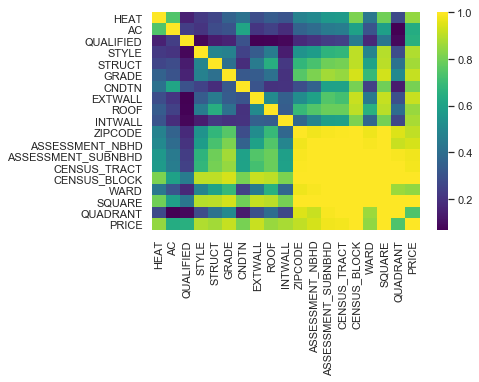

In [33]:
g = sns.heatmap(df.astype(float), cmap = "viridis")
plt.show()

In [39]:
df = paired_corr(data[numeric_cols])
df

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,YR_RMDL,STORIES,PRICE,SALE_NUM,GBA,LANDAREA
BATHRM,1,0.108451,0.412446,0.63592,0.62785,0.180149,0.0262276,0.493812,0.0704513,0.688622,0.280118
HF_BATHRM,0.108451,1,-0.173995,0.0852035,0.118604,0.0770022,0.0325544,0.277297,0.00782113,0.240594,0.133005
NUM_UNITS,0.412446,-0.173995,1,0.566168,0.367978,0.0346291,0.00886321,0.00718951,-0.00851176,0.32641,-0.0403307
ROOMS,0.63592,0.0852035,0.566168,1,0.678659,0.0458601,0.0236264,0.318091,-0.00605563,0.676385,0.268252
BEDRM,0.62785,0.118604,0.367978,0.678659,1,0.0883877,0.0240735,0.348007,0.00684011,0.641371,0.276777
YR_RMDL,0.180149,0.0770022,0.0346291,0.0458601,0.0883877,1,0.00848088,0.207572,0.154843,0.0647707,-0.0329886
STORIES,0.0262276,0.0325544,0.00886321,0.0236264,0.0240735,0.00848088,1,0.0456391,0.010226,0.0407315,-0.0141883
PRICE,0.493812,0.277297,0.00718951,0.318091,0.348007,0.207572,0.0456391,1,0.196723,0.58814,0.314802
SALE_NUM,0.0704513,0.00782113,-0.00851176,-0.00605563,0.00684011,0.154843,0.010226,0.196723,1,-0.0491853,-0.051157
GBA,0.688622,0.240594,0.32641,0.676385,0.641371,0.0647707,0.0407315,0.58814,-0.0491853,1,0.450779


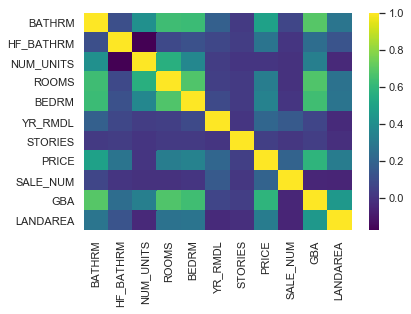

In [40]:

g = sns.heatmap(df.astype(float), cmap = "viridis")
plt.show()

In [36]:
df2 = paired_contincency(data[numeric_cols])
df2

,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,YR_RMDL,STORIES,PRICE,SALE_NUM,GBA,LANDAREA
BATHRM,1,0.324846,0.590928,0.764594,0.784384,0.303186,0.399567,0.919275,0.134721,0.965834,0.950548
HF_BATHRM,0.324846,1,0.236189,0.776381,0.25686,0.177123,0.268762,0.846176,0.0711719,0.905432,0.839432
NUM_UNITS,0.590928,0.236189,1,0.683309,0.506675,0.196704,0.251353,0.854297,0.0560062,0.868417,0.835578
ROOMS,0.764594,0.776381,0.683309,1,0.858006,0.34473,0.430584,0.943431,0.0970068,0.975461,0.967603
BEDRM,0.784384,0.25686,0.506675,0.858006,1,0.298297,0.422548,0.888328,0.0874508,0.959505,0.957997
YR_RMDL,0.303186,0.177123,0.196704,0.34473,0.298297,1,0.233363,0.968125,0.427701,0.951681,0.975407
STORIES,0.399567,0.268762,0.251353,0.430584,0.422548,0.233363,1,0.94196,0.0936957,0.940627,0.95055
PRICE,0.919275,0.846176,0.854297,0.943431,0.888328,0.968125,0.94196,1,0.830918,0.99941,0.999672
SALE_NUM,0.134721,0.0711719,0.0560062,0.0970068,0.0874508,0.427701,0.0936957,0.830918,1,0.665568,0.812403
GBA,0.965834,0.905432,0.868417,0.975461,0.959505,0.951681,0.940627,0.99941,0.665568,1,0.999703


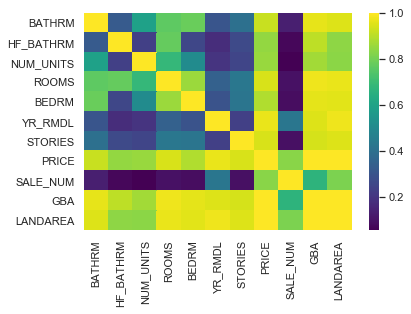

In [37]:
g = sns.heatmap(df2.astype(float), cmap = "viridis")
plt.show()

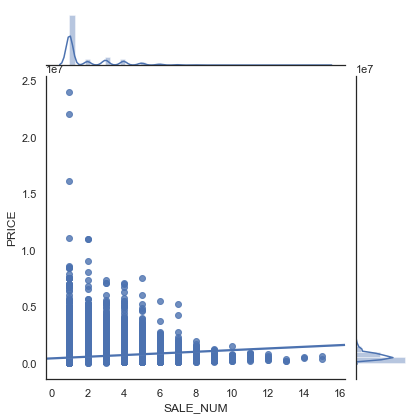

In [71]:
g = sns.jointplot(data.SALE_NUM, data.PRICE, kind='reg')
plt.show()

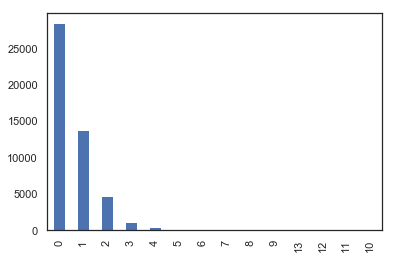

In [76]:
data.FIREPLACES.value_counts().plot(kind='bar')
plt.show()

In [31]:
df = paired_contincency(data[categorical_cols])

In [49]:
data["STORIES"].unique()

array([3.00e+00, 4.00e+00, 2.00e+00, 2.50e+00, 3.50e+00, 1.00e+00,
       3.25e+00, 1.50e+00, 2.25e+00, 2.70e+00, 8.26e+02, 2.75e+00,
       6.00e+00, 2.30e+00, 2.20e+00, 3.70e+00, 1.70e+00, 1.75e+00,
       2.50e+02, 2.75e+02, 1.25e+00, 3.75e+00, 5.00e+00, 0.00e+00,
       9.00e+00, 8.25e+00, 2.00e+01, 2.50e-01])